In [3]:
import os
import time
import warnings
import sqlite3
import requests
from datetime import datetime
from html.parser import HTMLParser
import math
import ast
from itertools import product
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from functools import reduce

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import (
    udf, count, collect_list, concat_ws, array_contains, flatten,
    col, lit, explode, array_distinct, size, countDistinct, mean, stddev
)

from pyspark.sql.types import StringType, ArrayType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression

from sklearn.metrics import silhouette_score

In [4]:
def frequencies(spark, start_year, end_year):
    dfs = []
    appearance_dfs = []

    for year in range(start_year, end_year + 1):
        df = spark.read.parquet(f'second_transformed_{year}')
        df = df.withColumn('flat_country_paths', explode(df.country_paths))

        # Get each country code as separate row
        exploded_df = df.withColumn("country_code", explode(col("flat_country_paths")))

          # Remove duplicate country codes in path
        deduplicated_df = exploded_df.groupBy("Path").agg(array_distinct(collect_list("country_code")).alias("unique_country_codes"), _sum("Frequency").alias("Frequency"))

        # Count frequencies
        exploded_deduplicated_df = deduplicated_df.withColumn("country_code", explode(col("unique_country_codes")))

        # Group the country code and sum frequencies
        country_frequency_df = exploded_deduplicated_df.groupBy("country_code").sum("Frequency")
        country_frequency_df = country_frequency_df.withColumnRenamed("sum(Frequency)", f"Total_Frequency_{year}")

        # Group the country code and count occurrences in original df
        country_appearance_df = exploded_df.groupBy("country_code").agg(count("Path").alias(f"Total_Appearances_{year}"))
        dfs.append(country_frequency_df)
        appearance_dfs.append(country_appearance_df)

    # Merge the dataframes for different years
    merged_df = dfs[0]
    for i in range(1, len(dfs)):
        merged_df = merged_df.join(dfs[i], "country_code", how="outer")

    # Merge the appearance dataframes
    appearance_merged_df = appearance_dfs[0]
    for i in range(1, len(appearance_dfs)):
        appearance_merged_df = appearance_merged_df.join(appearance_dfs[i], "country_code", how="outer")

    # Replace missing values 
    merged_df = merged_df.fillna(0)
    appearance_merged_df = appearance_merged_df.fillna(0)
    
    # Add Column with summed frequency 
    frequency_sum_expr = " + ".join(merged_df.columns[1:])
    merged_df = merged_df.selectExpr("*", f"({frequency_sum_expr}) as Total_Frequency_Sum")
    
    # Add Column with summed appearances
    appearance_sum_expr = " + ".join(appearance_merged_df.columns[1:])
    appearance_merged_df = appearance_merged_df.selectExpr("*", f"({appearance_sum_expr}) as Total_Appearance_Sum")

    final_df = merged_df.join(appearance_merged_df, "country_code")

    return final_df

def add_percentage_columns(df):
    # Get total frequency for each year of a=ll countries
    frequency_columns = [col for col in df.columns if col.startswith("Total_Frequency_") and col != "Total_Frequency_Sum"]
    frequency_totals = df.select([_sum(col).alias(col) for col in frequency_columns]).collect()[0].asDict()

    # Get total appearance for each year of all countries
    appearance_columns = [col for col in df.columns if col.startswith("Total_Appearances_") and col != "Total_Appearance_Sum"]
    appearance_totals = df.select([_sum(col).alias(col) for col in appearance_columns]).collect()[0].asDict()

    # Add percentage columns frequencies
    for freq_col in frequency_columns:
        year_total = frequency_totals[freq_col]
        percentage_col = f"Percentage_{freq_col}"
        df = df.withColumn(percentage_col, (col(freq_col) / year_total) * 100)

    # Add percentage columns appearances
    for app_col in appearance_columns:
        year_total = appearance_totals[app_col]
        percentage_col = f"Percentage_{app_col}"
        df = df.withColumn(percentage_col, (col(app_col) / year_total) * 100)
    
    return df

def normalize_dataframe(df):
    # Define the columns to be summed
    frequency_columns = [f"Total_Frequency_{year}" for year in range(2016, 2023)]
    appearance_columns = [f"Total_Appearances_{year}" for year in range(2016, 2023)]

      # Columns for total sums
    df = df.withColumn("Total_Frequency_Sum", reduce(lambda a, b: a + b, [col(c) for c in frequency_columns]))
    df = df.withColumn("Total_Appearances_Sum", reduce(lambda a, b: a + b, [col(c) for c in appearance_columns]))

    # Create global sums
    country_frequency_sum = df.agg(_sum("Total_Frequency_Sum").alias("Global_Frequency_Sum")).collect()[0][0]
    country_appearance_sum = df.agg(_sum("Total_Appearances_Sum").alias("Global_Appearance_Sum")).collect()[0][0]

    # Add scaling factors
    df = df.withColumn("Frequency_Scaling_Factor", col("Total_Frequency_Sum") / lit(country_frequency_sum))
    df = df.withColumn("Appearance_Scaling_Factor", col("Total_Appearances_Sum") / lit(country_appearance_sum))

    # Apply the scaling factor to normalize the values
    for year in range(2016, 2023):
        df = df.withColumn(f"Normalized_Total_Frequency_{year}",
                           col(f"Total_Frequency_{year}") / col("Frequency_Scaling_Factor"))
        df = df.withColumn(f"Normalized_Total_Appearances_{year}",
                           col(f"Total_Appearances_{year}") / col("Appearance_Scaling_Factor"))
     # Handle missing values with zeros
    normalized_columns = [f"Normalized_Total_Frequency_{year}" for year in range(2016, 2023)] + \
                         [f"Normalized_Total_Appearances_{year}" for year in range(2016, 2023)]
    df = df.fillna(0, subset=normalized_columns)

    return df


# Creating the dataset

In [5]:
spark = SparkSession.builder \
    .appName("Grote datasets") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

24/06/30 12:44:23 WARN Utils: Your hostname, BIGBOY resolves to a loopback address: 127.0.1.1; using 192.168.178.27 instead (on interface eno2)
24/06/30 12:44:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/30 12:44:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Transform dataset to get features
df_kh = frequencies(spark, 2016, 2022)
df_no_kh = df_kh.filter(col('country_code') != 'KH')

In [5]:
# Add percentage features
df = add_percentage_columns(df_no_kh)
df.show()

24/06/28 22:36:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+
|country_code|Total_Frequency_2016|Total_Frequency_2017|Total_Frequency_2018|Total_Frequency_2019|Total_Frequency_2020|Total_Frequency_2021|Total_Frequency_2022|Total_Frequen

In [6]:
# Add normalized features
add_normalized_df = normalize_dataframe(df)
pandas_df = add_normalized_df.toPandas()
sorted_df = pandas_df.sort_values(by='Total_Appearance_Sum', ascending=False)
sorted_df[:15]

,country_code,Total_Frequency_2016,Total_Frequency_2017,Total_Frequency_2018,Total_Frequency_2019,Total_Frequency_2020,Total_Frequency_2021,Total_Frequency_2022,Total_Frequency_Sum,Total_Appearances_2016,...,Normalized_Total_Frequency_2018,Normalized_Total_Appearances_2018,Normalized_Total_Frequency_2019,Normalized_Total_Appearances_2019,Normalized_Total_Frequency_2020,Normalized_Total_Appearances_2020,Normalized_Total_Frequency_2021,Normalized_Total_Appearances_2021,Normalized_Total_Frequency_2022,Normalized_Total_Appearances_2022
217,US,13053310,27967880,66152280,74209988,71171911,45430112,39796459,337781940,176127,...,2.189369e+08,1.153556e+06,2.456046e+08,1.033778e+06,2.355498e+08,1.040124e+06,1.503550e+08,1.006477e+06,1.317099e+08,6.488723e+05
29,BR,1674006,3980730,6959030,25805994,11106257,9541230,3799565,62866812,43422,...,1.237479e+08,8.908308e+05,4.588911e+08,1.158111e+06,1.974953e+08,1.161858e+06,1.696655e+08,1.082394e+06,6.756518e+07,6.931955e+05
185,SE,8666118,11709239,16045350,16238818,10436230,5640368,5247729,73983852,55211,...,2.424503e+08,1.139391e+06,2.453737e+08,1.079626e+06,1.576947e+08,1.078609e+06,8.522775e+07,5.856953e+05,7.929485e+07,3.535370e+05
18,BD,111172,314623,836061,475810,4605122,2252175,854310,9449273,4280,...,9.891225e+07,5.187703e+05,5.629187e+07,5.249200e+05,5.448203e+08,1.833191e+06,2.664491e+08,2.081584e+06,1.010712e+08,1.061268e+06
88,HK,2798646,10650585,8382605,8321220,25554829,10199484,14425134,80332503,17029,...,1.166536e+08,1.117225e+06,1.157994e+08,1.030576e+06,3.556249e+08,7.058714e+05,1.419376e+08,1.307323e+06,2.007424e+08,9.613650e+05
97,IN,2137199,5833110,2743305,2091450,2674340,3695091,1568725,20743220,13609,...,1.478456e+08,9.041581e+05,1.127150e+08,9.285624e+05,1.441289e+08,1.157660e+06,1.991404e+08,1.184350e+06,8.454368e+07,9.304770e+05
179,RU,1377019,1769168,2037801,2309969,2787586,1614395,665557,12561495,22546,...,1.813556e+08,9.620303e+05,2.055774e+08,1.101607e+06,2.480833e+08,7.939968e+05,1.436743e+08,1.410647e+06,5.923173e+07,3.906070e+05
71,GB,1208881,4909380,5293049,3655652,6817282,2884610,4122858,28891712,11757,...,2.048062e+08,1.220762e+06,1.414497e+08,7.799579e+05,2.637840e+08,6.639436e+05,1.116155e+08,7.228354e+05,1.595275e+08,6.791510e+05
225,VN,2620841,1765528,6935131,5361260,26605094,6335823,6269813,55893490,27159,...,1.387088e+08,1.233748e+06,1.072300e+08,1.031610e+06,5.321255e+08,8.512111e+05,1.267221e+08,7.934264e+05,1.254018e+08,6.756096e+05
93,ID,181149,1063848,1099302,991488,608076,1658739,1069744,6672346,6610,...,1.841828e+08,9.887951e+05,1.661190e+08,1.046579e+06,1.018802e+08,9.812726e+05,2.779137e+08,1.032704e+06,1.792305e+08,9.927514e+05


# Creating Plots and Clustering


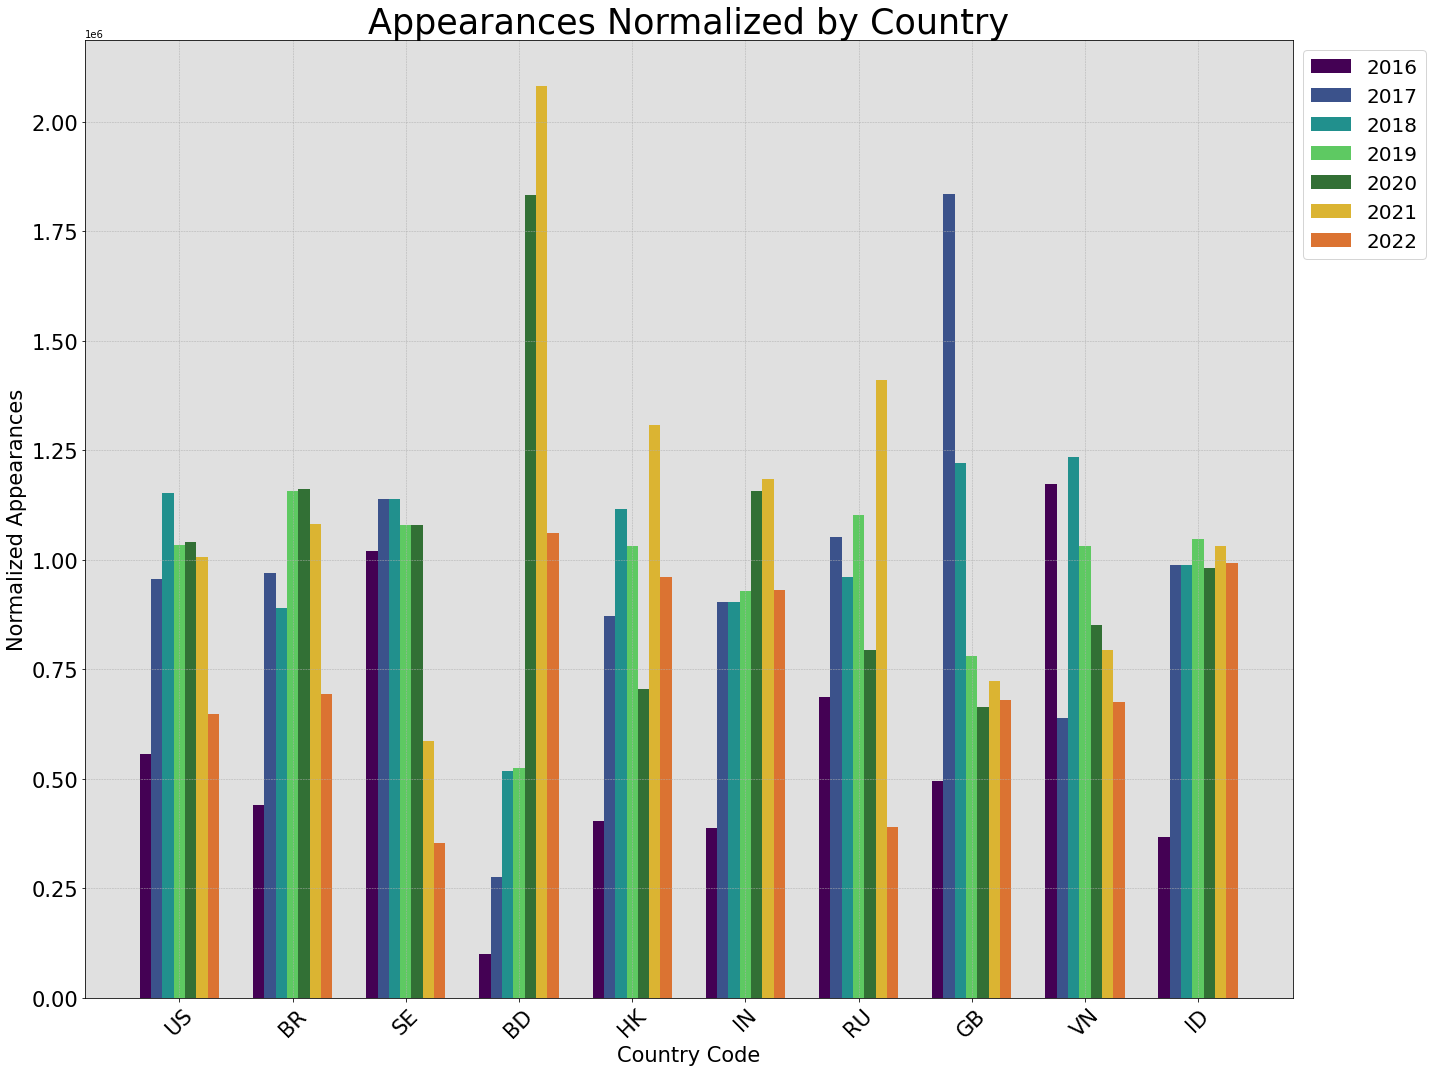

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_category(df, category, mode=None, start_year=2016, end_year=2022, top_n=25):
    # Sort by total sum for the selected category
    total_sum_col = f"Total_{category}_Sum"
    sorted_df = df.orderBy(total_sum_col, ascending=False)
    pandas_df = sorted_df.toPandas()

    # Get top N rows
    country_codes = pandas_df["country_code"].head(top_n).tolist()
    if mode is None:
        values_by_year = {year: pandas_df[f"Total_{category}_{year}"].head(top_n).tolist() for year in range(start_year, end_year + 1)}
    else:
        values_by_year = {year: pandas_df[f"{mode}_Total_{category}_{year}"].head(top_n).tolist() for year in range(start_year, end_year + 1)}

    bar_width = 0.1
    positions = np.arange(len(country_codes))
    fig, ax = plt.subplots(figsize=(20, 15))
    custom_colors = ['#440154', '#3b528b', '#21908d', '#5ec962', '#327035', '#dbb432', '#db7332']

    # Extend the color palette if there are more years than colors
    if len(range(start_year, end_year + 1)) > len(custom_colors):
        custom_colors = custom_colors * ((len(range(start_year, end_year + 1)) // len(custom_colors)) + 1)

    # Plot bars for each year
    for i, year in enumerate(range(start_year, end_year + 1)):
        ax.bar(positions + i * bar_width, values_by_year[year], bar_width, label=str(year), color=custom_colors[i])

    ax.set_facecolor('#e0e0e0')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax.set_xlabel('Country Code', fontsize=21) 
    ax.set_ylabel(f'Normalized {category}', fontsize=21)  
    if mode is None:
        ax.set_title(f'Total {category}', fontsize=35)  
    else:
        ax.set_title(f'{category} Normalized by Country', fontsize=35)  

    ax.set_xticks(positions + (bar_width * (end_year - start_year) / 2))
    ax.set_xticklabels(country_codes, fontsize=21)  
    ax.tick_params(axis='y', labelsize=21)

    # Place the legend outside the plot
    ax.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# categories: 'Appearances', 'Frequency', mode='Normalized', 'Percentage', None
plot_category(add_normalized_df, category='Appearances', mode='Normalized', start_year=2016, end_year=2022, top_n=10)


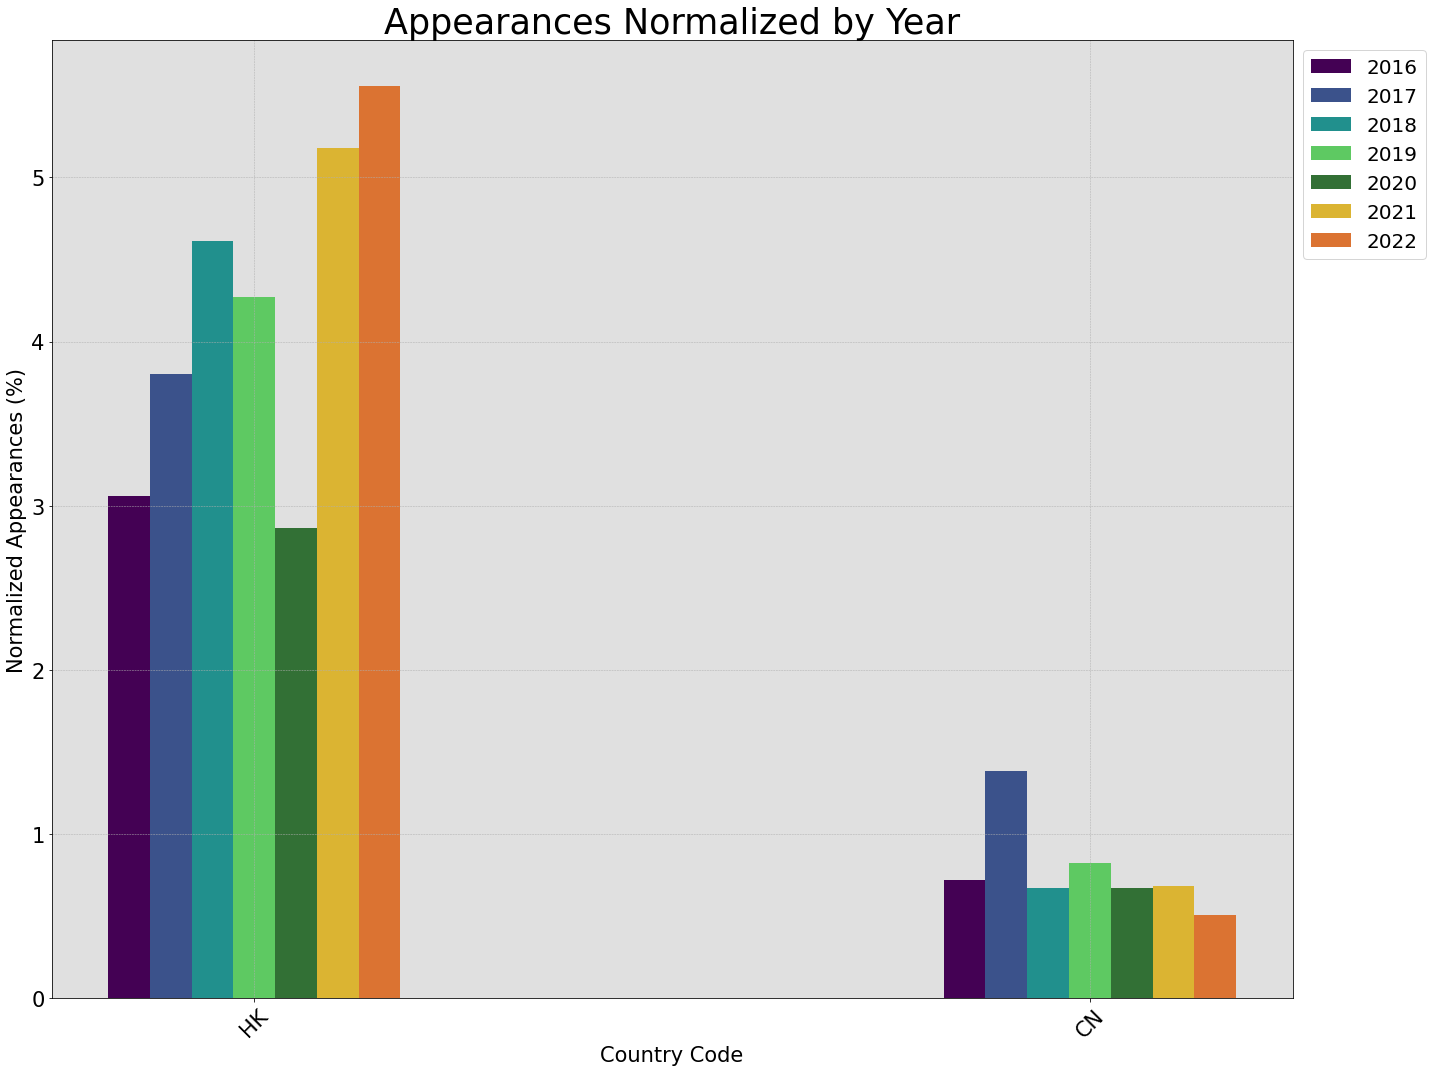

In [11]:
def plot_category(df, category, mode=None, start_year=2016, end_year=2022):
    # Sort by total sum for the selected category
    total_sum_col = f"Total_{category}_Sum"
    sorted_df = df.orderBy(total_sum_col, ascending=False)
    pandas_df = sorted_df.toPandas()

    # Indices of countries to be plotted
    indices = [4, 23] 
    country_codes = pandas_df["country_code"].iloc[indices].tolist()
    
    if mode is None:
        values_by_year = {year: pandas_df[f"Total_{category}_{year}"].iloc[indices].tolist() for year in range(start_year, end_year + 1)}
    else:
        values_by_year = {year: pandas_df[f"{mode}_Total_{category}_{year}"].iloc[indices].tolist() for year in range(start_year, end_year + 1)}

    bar_width = 0.05  
    positions = np.arange(len(country_codes))
    fig, ax = plt.subplots(figsize=(20, 15))
    custom_colors = ['#440154', '#3b528b', '#21908d', '#5ec962', '#327035', '#dbb432', '#db7332']

    # Extend the color palette if there are more years than colors
    if len(range(start_year, end_year + 1)) > len(custom_colors):
        custom_colors = custom_colors * ((len(range(start_year, end_year + 1)) // len(custom_colors)) + 1)

    # Plot bars for each year
    for i, year in enumerate(range(start_year, end_year + 1)):
        ax.bar(positions + i * bar_width, values_by_year[year], bar_width, label=str(year), color=custom_colors[i])

    ax.set_facecolor('#e0e0e0')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax.set_xlabel('Country Code', fontsize=21)
    ax.set_ylabel(f'Normalized Appearances (%)', fontsize=21)
    if mode is None:
        ax.set_title(f'Total {category} by Country Code and Year', fontsize=25)
    else:
        ax.set_title(f'{category} Normalized by Year', fontsize=35)

    ax.set_xticks(positions + (bar_width * (end_year - start_year) / 2))
    ax.set_xticklabels(country_codes, fontsize=21)
    ax.tick_params(axis='y', labelsize=21)

    # Place the legend outside the plot
    ax.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# categories: 'Appearances', 'Frequency', mode='Normalized', 'Percentage', None
plot_category(add_normalized_df, category='Appearances', mode='Percentage', start_year=2016, end_year=2022)


In [231]:
def dynamic_feature_engineering(df, include_frequencies=True, include_appearances=True, include_normalized_frequency=True, include_normalized_appearances=True):
    input_cols = []
    if include_frequencies:
        input_cols += [col for col in df.columns if col.startswith("Total_Frequency_")]
    if include_appearances:
        input_cols += [col for col in df.columns if col.startswith("Total_Appearances_")]
    if include_normalized_frequency:
        input_cols += [col for col in df.columns if col.startswith("Normalized_Total_Frequency_")]
    if include_normalized_appearances:
        input_cols += [col for col in df.columns if col.startswith("Normalized_Total_Appearances_")]
    if include_percentage_frequencies:
        input_cols += [col for col in df.columns if col.startswith("Percentage_Total_Frequency_")]
    if include_percentage_appearances:
        input_cols += [col for col in df.columns if col.startswith("Percentage_Total_Appearances_")]
    # Drop rows with any null values
    df = df.na.drop(subset=input_cols)
    # Features
    assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
    df_features = assembler.transform(df)
    
    return df_features

def run_kmeans_clustering(df, k=4):

    kmeans = KMeans(k=k, seed=1) 
    model = kmeans.fit(df)
    predictions = model.transform(df)

    # Show cluster centers
    centers = model.clusterCenters()
#     print("Cluster Centers: ")
#     for center in centers:
#         print(center)

    return predictions

def plot_clusters(predictions, k):
    pandas_df = predictions.select('country_code', 'features', 'prediction').toPandas()
    feature_df = pd.DataFrame(pandas_df['features'].tolist(), index=pandas_df.index)
    pandas_df = pandas_df.drop('features', axis=1).join(feature_df)
    pandas_df = pandas_df.rename(columns={'prediction': 'Cluster'})

    # Extract feature columns
    feature_cols = [col for col in pandas_df.columns if col not in ['country_code', 'Cluster']]

    # Apply PCA
    principal_components = PCA(n_components=2).fit_transform(pandas_df[feature_cols])

    # DataFrame with the principal components and clusters 
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = pandas_df['Cluster']
    pca_df['country_code'] = pandas_df['country_code']

    custom_colors = ['#440154', '#3b528b', '#21908d', '#5ec962', '#327035', '#dbb432', '#db7332']

    plt.figure(figsize=(10, 8))
    for cluster in range(k):
        cluster_data = pca_df[pca_df['Cluster'] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', s=100, color=custom_colors[cluster % len(custom_colors)])

    plt.gca().set_facecolor('#f0f0f0')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.title('Clusters of Country Connectivity Frequencies', fontsize=20)
    plt.xlabel('Principal Component 1', fontsize=16)
    plt.ylabel('Principal Component 2', fontsize=16)
    plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.tight_layout()
    plt.show()

    # Group by cluster to list countries in each cluster
    clusters = pandas_df.groupby('Cluster')['country_code'].apply(list).reset_index()
    clusters.columns = ['Cluster', 'Countries']

    for _, row in clusters.iterrows():
        print(f"Cluster {row['Cluster']}: {row['Countries']}")
    return clusters

### Frequency feature has been removed from final solution, so you can discard it

In [176]:
include_appearances = True # Frequentie based and without duplicates
include_frequencies = False # Frequentie based and without duplicates
include_normalized_frequencies = False # Behavior based with duplicates
include_percentage_frequencies = False # Frequentie based and without duplicates
include_normalized_appearances = True # Behavior based and without duplicates
include_percentage_appearances = True # Frequentie based and without duplicates


df_features = dynamic_feature_engineering(add_normalized_df, 
                                          include_frequencies, 
                                          include_appearances, 
                                          include_normalized_frequencies, 
                                          include_normalized_appearances)

predictions = run_kmeans_clustering(df_features, k=6)



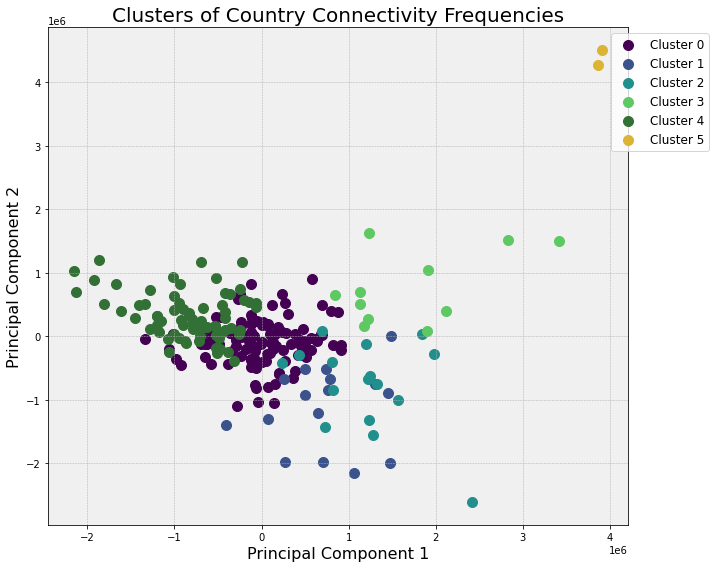

Cluster 0: ['AF', 'AG', 'AL', 'AM', 'AR', 'AT', 'AU', 'AW', 'AX', 'AZ', 'BG', 'BH', 'BJ', 'BO', 'BR', 'BY', 'BZ', 'CA', 'CD', 'CF', 'CH', 'CK', 'CL', 'CO', 'CZ', 'DE', 'DJ', 'DK', 'EC', 'EE', 'EG', 'ES', 'ET', 'FI', 'FJ', 'FR', 'GA', 'GD', 'GF', 'GH', 'GL', 'GQ', 'GR', 'GT', 'HK', 'HN', 'HT', 'ID', 'IE', 'IL', 'IN', 'IR', 'IS', 'IT', 'JE', 'KE', 'KY', 'KZ', 'LA', 'LB', 'LS', 'LU', 'LY', 'MA', 'MD', 'ME', 'MG', 'MM', 'MR', 'MU', 'MV', 'MX', 'MZ', 'NA', 'NG', 'NL', 'NO', 'PE', 'PF', 'PG', 'PH', 'PL', 'PM', 'PR', 'PS', 'PT', 'PY', 'RE', 'RU', 'SB', 'SC', 'SD', 'SE', 'SG', 'SI', 'SK', 'SN', 'SV', 'SX', 'SZ', 'TC', 'TG', 'TH', 'TK', 'TL', 'TN', 'TR', 'TW', 'UA', 'UG', 'US', 'UY', 'UZ', 'VE', 'VG', 'VN', 'YE', 'ZA', 'ZM', 'ZW']
Cluster 1: ['AO', 'BD', 'BE', 'BF', 'BN', 'BW', 'CV', 'DZ', 'GN', 'IQ', 'KM', 'MW', 'NF', 'NP', 'SR', 'WF']
Cluster 2: ['BQ', 'CI', 'CU', 'FK', 'GM', 'GW', 'MC', 'MH', 'ML', 'NE', 'RW', 'SL', 'SO', 'ST', 'SY', 'TZ']
Cluster 3: ['BT', 'CM', 'DO', 'ER', 'KI', 'NR', 'PA'

In [232]:
clusters = plot_clusters(predictions, k=6)

In [178]:
cs = ['US','BR','BD','SE','HK','CN','YT','NE','SS']
for i in cs:
    cluster_info = clusters[clusters['Countries'].apply(lambda x: i in x)]
    print(cluster_info)

   Cluster                                          Countries
0        0  [AF, AG, AL, AM, AR, AT, AU, AW, AX, AZ, BG, B...
   Cluster                                          Countries
0        0  [AF, AG, AL, AM, AR, AT, AU, AW, AX, AZ, BG, B...
   Cluster                                          Countries
1        1  [AO, BD, BE, BF, BN, BW, CV, DZ, GN, IQ, KM, M...
   Cluster                                          Countries
0        0  [AF, AG, AL, AM, AR, AT, AU, AW, AX, AZ, BG, B...
   Cluster                                          Countries
0        0  [AF, AG, AL, AM, AR, AT, AU, AW, AX, AZ, BG, B...
   Cluster                                          Countries
4        4  [AD, AE, AI, AS, BA, BB, BI, BM, BS, CG, CN, C...
   Cluster Countries
5        5  [AP, YT]
   Cluster                                          Countries
2        2  [BQ, CI, CU, FK, GM, GW, MC, MH, ML, NE, RW, S...
   Cluster                                     Countries
3        3  [BT, CM, DO, ER, KI, 

In [179]:
clusters

,Cluster,Countries
0,0,"[AF, AG, AL, AM, AR, AT, AU, AW, AX, AZ, BG, B..."
1,1,"[AO, BD, BE, BF, BN, BW, CV, DZ, GN, IQ, KM, M..."
2,2,"[BQ, CI, CU, FK, GM, GW, MC, MH, ML, NE, RW, S..."
3,3,"[BT, CM, DO, ER, KI, NR, PA, PK, SS, TD, TV]"
4,4,"[AD, AE, AI, AS, BA, BB, BI, BM, BS, CG, CN, C..."
5,5,"[AP, YT]"


In [182]:
def calculate_wcss_silhouette(df, k_range):
    wcss = []
    sil_scores = []

    for k in k_range:
        kmeans = KMeans(k=k, seed=1)
        model = kmeans.fit(df)
        predictions = model.transform(df)
        wcss.append(model.summary.trainingCost)
        
        # Extract predictions for silhouette score calculation
        preds = predictions.select('prediction').toPandas().values.flatten()
        features = predictions.select('features').toPandas()
        features_list = features['features'].tolist()
        features_array = np.array([list(row) for row in features_list])
        
        sil_scores.append(silhouette_score(features_array, preds))

    return wcss, sil_scores


def plot_elbow_silhouette(wcss, sil_scores, k_range):
    plt.figure(figsize=(12, 5))
    
    # Custom colors
    line_color = '#1f77b4'  # Deep blue color

    # Plot WCSS
    plt.subplot(1, 2, 1)
    plt.plot(k_range, wcss, 'o-', color=line_color)
    plt.xlabel('Number of clusters (k)', fontsize=16)
    plt.ylabel('WCSS', fontsize=16)
    plt.title('Elbow Method for Optimal k', fontsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')

    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range, sil_scores, 'o-', color=line_color)
    plt.xlabel('Number of clusters (k)', fontsize=16)
    plt.ylabel('Silhouette Score', fontsize=16)
    plt.title('Silhouette Scores for Optimal k', fontsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')

    plt.tight_layout()
    plt.show()

    
k_range = range(2, 11)

# Calculate Scores
wcss, sil_scores = calculate_wcss_silhouette(df_features, k_range)     


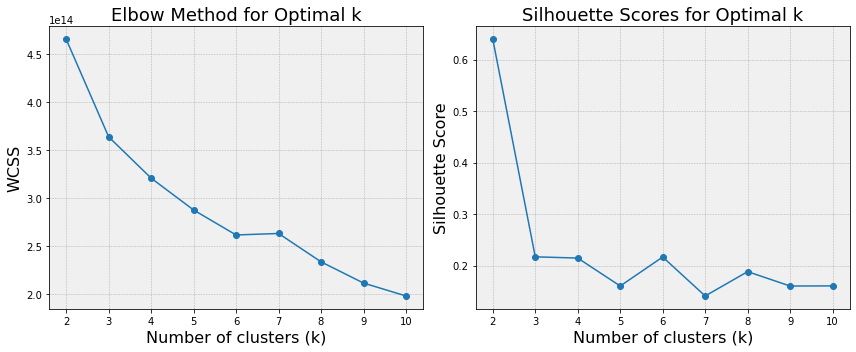

In [183]:
plot_elbow_silhouette(wcss, sil_scores, k_range)

# Regression

In [9]:
# selected_columns = [col(column) for column in add_normalized_df.columns if (column.startswith('Total_Appearances_') or column.startswith('Total_Frequency_')) and not column.endswith('_Sum')] + [col('country_code')]
selected_columns = [col(column) for column in add_normalized_df.columns if (column.startswith('Total_Appearances_') or column.startswith('Total_Frequency_')or column.startswith('Normalized_Total_Appearances_')) and not column.endswith('_Sum')] + [col('country_code')]

# Creating the new DataFrame with the selected columns
features = add_normalized_df.select(selected_columns)
d = features.toPandas()
d

,Total_Frequency_2016,Total_Frequency_2017,Total_Frequency_2018,Total_Frequency_2019,Total_Frequency_2020,Total_Frequency_2021,Total_Frequency_2022,Total_Appearances_2016,Total_Appearances_2017,Total_Appearances_2018,...,Total_Appearances_2021,Total_Appearances_2022,Normalized_Total_Appearances_2016,Normalized_Total_Appearances_2017,Normalized_Total_Appearances_2018,Normalized_Total_Appearances_2019,Normalized_Total_Appearances_2020,Normalized_Total_Appearances_2021,Normalized_Total_Appearances_2022,country_code
0,347,1115,518,512,420,432,0,6,10,7,...,4,0,1.129009e+06,1.881682e+06,1.317177e+06,7.526728e+05,5.645046e+05,7.526728e+05,0.000000e+00,AD
1,559562,4654030,281794,277725,339013,293445,352698,2048,3153,1511,...,1433,1494,9.678334e+05,1.490029e+06,7.140607e+05,9.512933e+05,8.912763e+05,6.771998e+05,7.060269e+05,AE
2,22142,33873,34211,25954,22096,58077,46215,438,1239,1035,...,1988,1681,3.152437e+05,8.917509e+05,7.449251e+05,7.233331e+05,1.081761e+06,1.430832e+06,1.209874e+06,AF
3,2429,8683,14412,20133,14547,11270,6597,79,136,172,...,180,137,4.763617e+05,8.200658e+05,1.037142e+06,8.683049e+05,1.284368e+06,1.085381e+06,8.260957e+05,AG
4,118,324,620,232,78,103,159,13,15,22,...,6,14,1.002052e+06,1.156214e+06,1.695781e+06,7.708095e+05,2.312429e+05,4.624857e+05,1.079133e+06,AI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,3352,9749,29324,19848,11162,15141,10830,195,341,287,...,311,191,6.467368e+05,1.130960e+06,9.518638e+05,1.094478e+06,9.087481e+05,1.031462e+06,6.334704e+05,YE
230,0,0,0,0,0,3287,6516,0,0,0,...,17,497,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.115977e+05,6.186121e+06,YT
231,73203,394924,1232722,1000374,16731159,447566,696029,1237,3600,3509,...,4392,4328,3.083208e+05,8.972958e+05,8.746141e+05,1.112896e+06,1.031142e+06,1.094701e+06,1.078749e+06,ZA
232,1502,47370,8850,10344,7878,17696,2711,33,88,189,...,193,88,2.065800e+05,5.508799e+05,1.183140e+06,1.546220e+06,1.151840e+06,1.208180e+06,5.508799e+05,ZM


In [10]:
def regression(df, country, year, clusters, scaling, normalized_appearances, percentage_appearances):
    "Scaling = 'target', 'all', None"
    # Initialize a list to hold the column prefixes
    prefixes = []
    

    if normalized_appearances:
        prefixes.append('Normalized_Total_Appearances_')
    if percentage_appearances:
        prefixes.append('Percentage_Total_Appearances_')
    prefixes.append('Total_Appearances_')

    selected_columns = [col(column) for column in df.columns if 
                        any(column.startswith(prefix) for prefix in prefixes) and not column.endswith('_Sum')] + [col('country_code')]
    
    # Creating new DataFrame with selected columns
    features = add_normalized_df.select(selected_columns)
    df = features

    # Define target country + year
    target_country = country  
    target_year = year

    pandas_df = df.toPandas()

    # Filter for training data (excluding target country and year)
    train_df_pandas = pandas_df[~((pandas_df["country_code"] == target_country) & 
                                  (pandas_df[f"Total_Appearances_{target_year}"] != pandas_df[f"Total_Appearances_{target_year}"]))]

    # Filter for testing data (only target country and year)
    test_df_pandas = pandas_df[(pandas_df["country_code"] == target_country)]

    train_df = spark.createDataFrame(train_df_pandas)
    test_df = spark.createDataFrame(test_df_pandas)

    # Feature columns (excluding target column and country_code)
    target_column = f"Total_Appearances_{target_year}"
    feature_columns = [col for col in train_df.columns if col not in ["country_code", target_column]]

    # Assemble feature vectors
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)

    # Keep country_code and target column in the final DataFrames
    train_df = train_df.select("country_code", "features", target_column)
    test_df = test_df.select("country_code", "features", target_column)
    
    cluster_info = clusters[clusters['Countries'].apply(lambda x: target_country in x)]
    if not cluster_info.empty:
        related_countries = cluster_info['Countries'].values[0]
    else:
        related_countries = []
        
    # Assign weights
    default_weight = 1.0
    higher_weight = 1.5

    def assign_weight(c):
        if c in related_countries[0]:
            return higher_weight
        else:
            return default_weight

    if scaling is None:
        
        # Prepare target columns for training and testing
        train_df = train_df.select("country_code", "features", col(target_column).cast("double").alias('label'))
        test_df = test_df.select("country_code","features", col(target_column).cast("double").alias('label'))
        assign_weight_udf = udf(assign_weight, DoubleType())
        train_df_weighted = train_df.withColumn("weight", assign_weight_udf(train_df["country_code"]))

        # Train the model
        rf = GBTRegressor(featuresCol="features", labelCol='label', weightCol="weight")
        model = rf.fit(train_df_weighted)
        
        # Make predictions
        predictions = model.transform(test_df)
        
    elif scaling == 'target':
          
        # Calculate mean and std
        mean_val = train_df.select(mean(target_column)).collect()[0][0]
        stddev_val = train_df.select(stddev(target_column)).collect()[0][0]

        # Normalize the target variable
        train_df = train_df.withColumn(f"Z_Normalized_{target_column}", 
                                       (col(target_column) - mean_val) / stddev_val)
        test_df = test_df.withColumn(f"Z_Normalized_{target_column}", 
                                     (col(target_column) - mean_val) / stddev_val)

        # Prepare target columns
        train_df = train_df.select("country_code", "features", col(f"Z_Normalized_{target_column}").alias("label"))
        test_df = test_df.select("country_code", "features", col(f"Z_Normalized_{target_column}").alias("label"))
        assign_weight_udf = udf(assign_weight, DoubleType())
        train_df_weighted = train_df.withColumn("weight", assign_weight_udf(train_df["country_code"]))

        # Train the model 
        rf = GBTRegressor(featuresCol="features", labelCol='label', weightCol="weight")
        model = rf.fit(train_df_weighted)

        # Make predictions
        predictions = model.transform(test_df)

        # Transform predictions to original scale
        predictions = predictions.withColumn("prediction_original", 
                                             (col("prediction") * stddev_val) + mean_val)
    elif scaling == 'all':
        # Normalize feature columns using StandardScaler
        scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
        scaler_model = scaler.fit(train_df)
        train_df = scaler_model.transform(train_df)
        test_df = scaler_model.transform(test_df)

        # Calculate mean and std
        mean_val = train_df.select(mean(target_column)).collect()[0][0]
        stddev_val = train_df.select(stddev(target_column)).collect()[0][0]

        # Normalize target variable
        train_df = train_df.withColumn(f"Z_Normalized_{target_column}", 
                                       (col(target_column) - mean_val) / stddev_val)
        test_df = test_df.withColumn(f"Z_Normalized_{target_column}", 
                                     (col(target_column) - mean_val) / stddev_val)
        
        # Prepare target columns for training and testing
        train_df = train_df.select("country_code", "scaled_features", col(f"Z_Normalized_{target_column}").alias("label"))
        test_df = test_df.select("country_code", "scaled_features", col(f"Z_Normalized_{target_column}").alias("label"))
        assign_weight_udf = udf(assign_weight, DoubleType())
        train_df_weighted = train_df.withColumn("weight", assign_weight_udf(train_df["country_code"]))
        # Train GBTRegressor model
        # RandomForestRegressor, GBTRegressor, DecisionTreeRegressor, LinearRegression
        rf = GBTRegressor(featuresCol="scaled_features", labelCol="label", weightCol="weight")
        model = rf.fit(train_df_weighted)

        # Make predictions
        predictions = model.transform(test_df)

        # Transform predictions to original scale
        predictions = predictions.withColumn("prediction_original", 
                                             (col("prediction") * stddev_val) + mean_val)
        
    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol='label', predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
#     print("Root Mean Squared Error (RMSE):", rmse)
#     predictions.show()
#     print(test_df_pandas[target_column])
    return predictions.select("prediction_original").collect()[0][0], test_df_pandas[target_column].iloc[0], rmse

## Call function once

In [42]:
frequency = False
normalized_frequency = False
percentage_frequency = False
normalized_appearances = True
percentage_appearances = True

preds, actual, scaled_RMSE = regression(
    df=add_normalized_df,
    country='MH',
    year='2016',
    clusters=clusters,
    scaling='all',
    normalized_appearances=normalized_appearances,
    percentage_appearances=percentage_appearances
)
print(preds, actual, scaled_RMSE)

6.29738736146146 12 0.0004497697006844714


## Optimization

#### Collect results for all parameter combinations

In [11]:
# Parameters
years = range(2016, 2023)  # 2016 to 2022
params = [True, False]
# Regular appearance are automaticly added
param_names = ['normalized_appearances', 'percentage_appearances']

# Generate all parameter combinations
combinations = list(product(params, repeat=len(param_names)))

# Pick only best combination after it is found
combinations = list([combinations[0]]) 
total_iterations = len(years) * len(combinations)
def create_results(country):
    results = []
    # Progress bar
    with tqdm(total=total_iterations) as pbar:
        for year in years:
            print(year)
            for combination in combinations:
                print(combination)
                # Create a dictionary for the parameters
                param_dict = dict(zip(param_names, combination))

                # Run the regression function
                preds, actual, scaled_RMSE = regression(
                    df=add_normalized_df,
                    #Picked countries that are most appearend + made sure every k group
                    country=country,
                    year=str(year),
                    clusters=clusters,
                    scaling='all',
                    normalized_appearances=param_dict['normalized_appearances'],
                    percentage_appearances=param_dict['percentage_appearances']
                )

                # Store results
                results.append({
                    'year': year,
                    'params': param_dict,
                    'preds': preds,
                    'actual': actual,
                    'scaled_RMSE': scaled_RMSE,
                })

                pbar.update(1)

    results_df = pd.DataFrame(results)
    results_df.to_csv(f'results3/{country}_regression_results_k6_w125.csv', index=False)

#### Run for parameter optimization

In [41]:
cs = ['US','BR','BD','SE','HK','CN','YT','NE','SS']

# List of all countries
all_countries = [country for sublist in clusters['Countries'] for country in sublist]

# Filter out countries listed in cs
filtered_countries = [country for country in all_countries if country not in cs]

# all_countries
for c in cs:
    create_results(c)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:11<01:08, 11.41s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:22<00:56, 11.38s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:34<00:46, 11.63s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:46<00:35, 11.72s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:57<00:23, 11.56s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [01:08<00:11, 11.36s/it]

2022
(True, True)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:11<01:07, 11.21s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:22<00:56, 11.23s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:32<00:43, 10.81s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:42<00:31, 10.41s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:52<00:20, 10.09s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [01:01<00:09,  9.85s/it]

2022
(True, True)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:09<00:58,  9.70s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:19<00:48,  9.64s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:29<00:40, 10.08s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:40<00:30, 10.31s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:49<00:19,  9.90s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [01:00<00:10, 10.15s/it]

2022
(True, True)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:10<01:04, 10.77s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:20<00:49,  9.93s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:29<00:38,  9.66s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:39<00:28,  9.63s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:50<00:20, 10.23s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [00:59<00:09,  9.89s/it]

2022
(True, True)
[1934,009s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 11854.0 (TID 50528): Retried waiting for GCLocker too often allocating 1048576 words


24/06/11 12:12:18 WARN TaskMemoryManager: Failed to allocate a page (8388592 bytes), try again.
  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:09<00:56,  9.34s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:18<00:45,  9.15s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:27<00:36,  9.19s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:36<00:27,  9.18s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:45<00:18,  9.12s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [00:54<00:09,  9.10s/it]

2022
(True, True)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:10<01:02, 10.39s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:20<00:52, 10.43s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:31<00:42, 10.50s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:40<00:29,  9.99s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:49<00:19,  9.68s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [01:00<00:09,  9.93s/it]

2022
(True, True)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:09<00:55,  9.17s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:19<00:49,  9.95s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:30<00:40, 10.24s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:40<00:30, 10.16s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:49<00:19,  9.93s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [01:00<00:10, 10.25s/it]

2022
(True, True)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:10<01:04, 10.73s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:21<00:54, 10.83s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:31<00:40, 10.21s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:41<00:31, 10.40s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:51<00:20, 10.06s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [01:02<00:10, 10.30s/it]

2022
(True, True)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

2016
(True, True)


 14%|██████▍                                      | 1/7 [00:10<01:03, 10.64s/it]

2017
(True, True)


 29%|████████████▊                                | 2/7 [00:20<00:49,  9.95s/it]

2018
(True, True)


 43%|███████████████████▎                         | 3/7 [00:30<00:41, 10.33s/it]

2019
(True, True)


 57%|█████████████████████████▋                   | 4/7 [00:40<00:30, 10.02s/it]

2020
(True, True)


 71%|████████████████████████████████▏            | 5/7 [00:50<00:19,  9.88s/it]

2021
(True, True)


 86%|██████████████████████████████████████▌      | 6/7 [01:00<00:10, 10.14s/it]

2022
(True, True)


100%|█████████████████████████████████████████████| 7/7 [01:10<00:00, 10.10s/it]


#### Find best considering all combinations for each country

In [11]:
### Calculate unscaled RMSE
def calculate_unscaled_rmse(row):
    preds = np.array([row['preds']]) 
    actual = np.array([row['actual']])
    return math.sqrt(mean_squared_error(actual, preds))

#USE RESULTS 2 for test data, and results for final predictor
results_dir = 'results3/'

# Dictionary to store unscaled RMSE values
unscaled_RMSE_values = {}

# Go over all country result files
for filename in os.listdir(results_dir):
    if filename.endswith('s_k6_w15.csv'):
        print(filename)
        results_df = pd.read_csv(os.path.join(results_dir, filename))

        # Calculate the unscaled RMSE for each row
        results_df['unscaled_RMSE'] = results_df.apply(calculate_unscaled_rmse, axis=1)
        unique_params = results_df['params'].unique()

        for params_to_match in unique_params:   
            results_filtered = results_df[results_df['params'] == params_to_match]

            # Calculate average unscaled RMSE
            average_unscaled_RMSE = results_filtered['unscaled_RMSE'].mean()

            if params_to_match in unscaled_RMSE_values:
                unscaled_RMSE_values[params_to_match].append(average_unscaled_RMSE)
            else:
                unscaled_RMSE_values[params_to_match] = [average_unscaled_RMSE]

# Calculate average unscaled RMSE for each parameter combination across all countries
average_unscaled_RMSE_values = {params: np.mean(values) for params, values in unscaled_RMSE_values.items()}

# Find lowest average unscaled RMSE parameters
best_param_combination = min(average_unscaled_RMSE_values, key=average_unscaled_RMSE_values.get)
best_average_unscaled_RMSE = average_unscaled_RMSE_values[best_param_combination]

print("Best Parameter Combination:", best_param_combination)
print("Average Unscaled RMSE:", best_average_unscaled_RMSE)
print('')
print('best',unscaled_RMSE_values.get(best_param_combination))
print('worst', unscaled_RMSE_values.get("{'frequency': False, 'normalized_frequency': False, 'percentage_frequency': False, 'normalized_appearances': False, 'percentage_appearances': False}"))

HK_regression_results_k6_w15.csv
US_regression_results_k6_w15.csv
SE_regression_results_k6_w15.csv
NE_regression_results_k6_w15.csv
YT_regression_results_k6_w15.csv
BR_regression_results_k6_w15.csv
BD_regression_results_k6_w15.csv
SS_regression_results_k6_w15.csv
CN_regression_results_k6_w15.csv
Best Parameter Combination: {'normalized_appearances': True, 'percentage_appearances': True}
Average Unscaled RMSE: 17.9530860504945

best [25.768603346264303, 12.460156608140096, 11.684466264126447, 6.366863929355331, 10.84774898740676, 13.448441761426304, 6.84411532294871, 15.384728573886994, 58.77264966089557]
worst None


### Display best combination

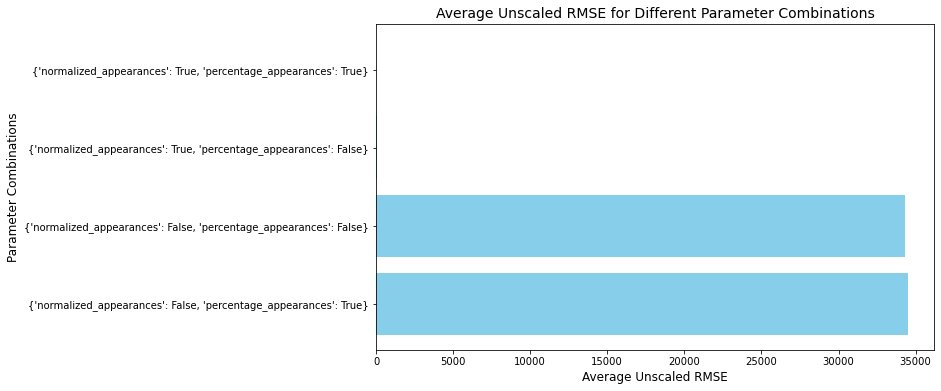

In [29]:
# run last code in /results2/ and ends with s.csv 

# Extract parameter combinations and average unscaled RMSE values
param_combinations = list(average_unscaled_RMSE_values.keys())
avg_unscaled_RMSEs = list(average_unscaled_RMSE_values.values())

# Sort parameter combinations based on average unscaled RMSE values
sorted_indices = sorted(range(len(avg_unscaled_RMSEs)), key=lambda k: avg_unscaled_RMSEs[k])
sorted_param_combinations = [param_combinations[i] for i in sorted_indices]
sorted_avg_unscaled_RMSEs = [avg_unscaled_RMSEs[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_param_combinations)), sorted_avg_unscaled_RMSEs, color='skyblue')
plt.yticks(range(len(sorted_param_combinations)), sorted_param_combinations, fontsize=10)
plt.xlabel('Average Unscaled RMSE', fontsize=12)
plt.ylabel('Parameter Combinations', fontsize=12)
plt.title('Average Unscaled RMSE for Different Parameter Combinations', fontsize=14)
plt.gca().invert_yaxis()
plt.show()


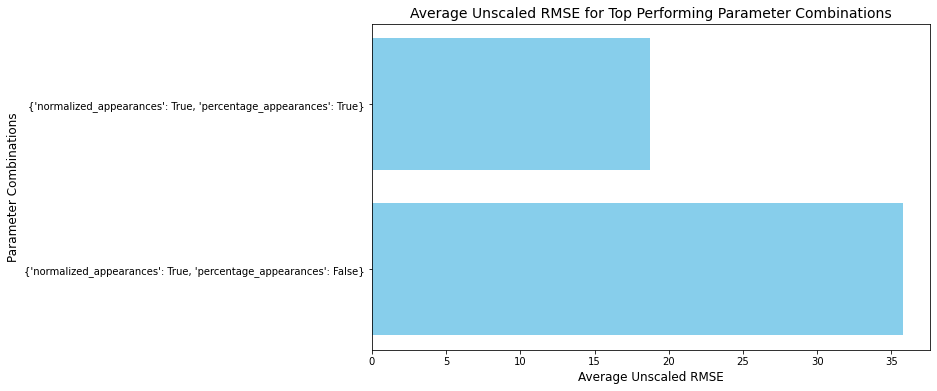

In [30]:
# run last code in /results2/ and ends with s.csv 

# Remove the 8 that perform very bad
top_param_combinations = sorted_param_combinations[:-2]
top_avg_unscaled_RMSEs = sorted_avg_unscaled_RMSEs[:-2]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_param_combinations)), top_avg_unscaled_RMSEs, color='skyblue')
plt.yticks(range(len(top_param_combinations)), top_param_combinations, fontsize=10)
plt.xlabel('Average Unscaled RMSE', fontsize=12)
plt.ylabel('Parameter Combinations', fontsize=12)
plt.title('Average Unscaled RMSE for Top Performing Parameter Combinations', fontsize=14)
plt.gca().invert_yaxis()
plt.show()


### Plot the performance

In [6]:
def reg_res(results_dir):
    #USE RESULTS 2 for test data, and results for final predictor
    results_dir = results_dir

    # Dictionary to store the unscaled RMSE values
    unscaled_RMSE_values = {}

    for filename in os.listdir(results_dir):
        if filename.endswith('.csv'):
            results_df = pd.read_csv(os.path.join(results_dir, filename))

            # Calculate unscaled RMSE for each row
            results_df['unscaled_RMSE'] = results_df.apply(calculate_unscaled_rmse, axis=1)
            unique_params = results_df['params'].unique()

            params_to_match = "{'normalized_appearances': True, 'percentage_appearances': True}"
            results_filtered = results_df[results_df['params'] == params_to_match]

            # Calculate average unscaled RMSE
            average_unscaled_RMSE = results_filtered['unscaled_RMSE'].mean()

            if params_to_match in unscaled_RMSE_values:
                unscaled_RMSE_values[params_to_match].append(average_unscaled_RMSE)
            else:
                unscaled_RMSE_values[params_to_match] = [average_unscaled_RMSE]

    # Calculate average unscaled RMSE for each parameter combination across all countries
    average_unscaled_RMSE_values = {params: np.mean(values) for params, values in unscaled_RMSE_values.items()}

    # Find lowest average unscaled RMSE parameters
    best_param_combination = min(average_unscaled_RMSE_values, key=average_unscaled_RMSE_values.get)
    best_average_unscaled_RMSE = average_unscaled_RMSE_values[best_param_combination]

    return average_unscaled_RMSE_values, unscaled_RMSE_values

In [7]:
# run last code in /results/ and ends with s.csv 
def acc(av, results_dir, values):
    Final = av["{'normalized_appearances': True, 'percentage_appearances': True}"]
    print(Final)

    name_list = []
    for filename in os.listdir(results_dir):
        if filename.endswith('.csv'):
            name_list.append(filename[:2])
    name_list
    output = values["{'normalized_appearances': True, 'percentage_appearances': True}"]

    # Plotting RMSE values with country names
    plt.figure(figsize=(18, 8))
    plt.plot(output, marker='o', linestyle='-', color='b', label='RMSE Values')
    plt.title('Unscaled RMSE Values by Country')
    plt.xlabel('Countries')
    plt.ylabel('RMSE Value')

    plt.xticks(ticks=range(len(name_list)), labels=name_list, rotation=90, ha='right', fontsize=8)
    plt.legend()
    plt.grid(True)
    plt.tight_layout() 
    plt.show()
    return output

In [8]:
def boxplot(output1, output2):
    plt.figure(figsize=(10, 6))
    
    # Custom colors
    box_color1 = '#1f77b4'  
    box_color2 = '#db7332'  
    median_color = '#030303'  

    # Boxplot properties
    boxprops1 = dict(facecolor=box_color1, color=box_color1)
    boxprops2 = dict(facecolor=box_color2, color=box_color2)
    medianprops = dict(color=median_color, linewidth=1.2)  # Custom median line properties
    
    bp1 = plt.boxplot(output1, positions=[1], widths=0.6, patch_artist=True,
                      boxprops=boxprops1, medianprops=medianprops)
    bp2 = plt.boxplot(output2, positions=[2], widths=0.6, patch_artist=True,
                      boxprops=boxprops2, medianprops=medianprops)
    

    plt.title('Box Plot of Unscaled RMSE Values by Country', fontsize=20)
    plt.xlabel('Countries', fontsize=16)
    plt.ylabel('RMSE Value', fontsize=16)
    plt.xticks([1, 2], ['With weighted clusters', 'Without weighted clusters'], rotation=0, fontsize=12)
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')
    
    plt.tight_layout()
    plt.show()

In [9]:
def outliers(output, results_dir):
    
    name_list = []
    for filename in os.listdir(results_dir):
        if filename.endswith('.csv'):
            name_list.append(filename[:2])
    
    # Convert to numpy array for Z-score calculation
    rmse_array = np.array(output)

    # Calculate 25th percentile and 75th percentile
    Q1 = np.percentile(rmse_array, 25)
    Q3 = np.percentile(rmse_array, 75)

    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers_iqr = (rmse_array < lower_bound) | (rmse_array > upper_bound)

    # Get the corresponding country names for the outliers
    outlier_countries_iqr = [name_list[i] for i in range(len(name_list)) if outliers_iqr[i]]
    outlier_values_iqr = [output[i] for i in range(len(name_list)) if outliers_iqr[i]]

    print("Outlier Countries (IQR):", outlier_countries_iqr)
    print("Outlier RMSE Values (IQR):", outlier_values_iqr)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(outlier_values_iqr)), outlier_values_iqr, color='red', label='Outliers (IQR)')
    plt.axhline(y=26.395, color='blue', linestyle='--', label='Average RMSE')
    plt.title('Outlier RMSE Values (IQR)')
    plt.xlabel('Countries')
    plt.ylabel('RMSE Value')
    plt.xticks(ticks=range(len(outlier_values_iqr)), labels=outlier_countries_iqr, rotation=90, ha='right', fontsize=8)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout() 
    plt.show()

25.895710742791874


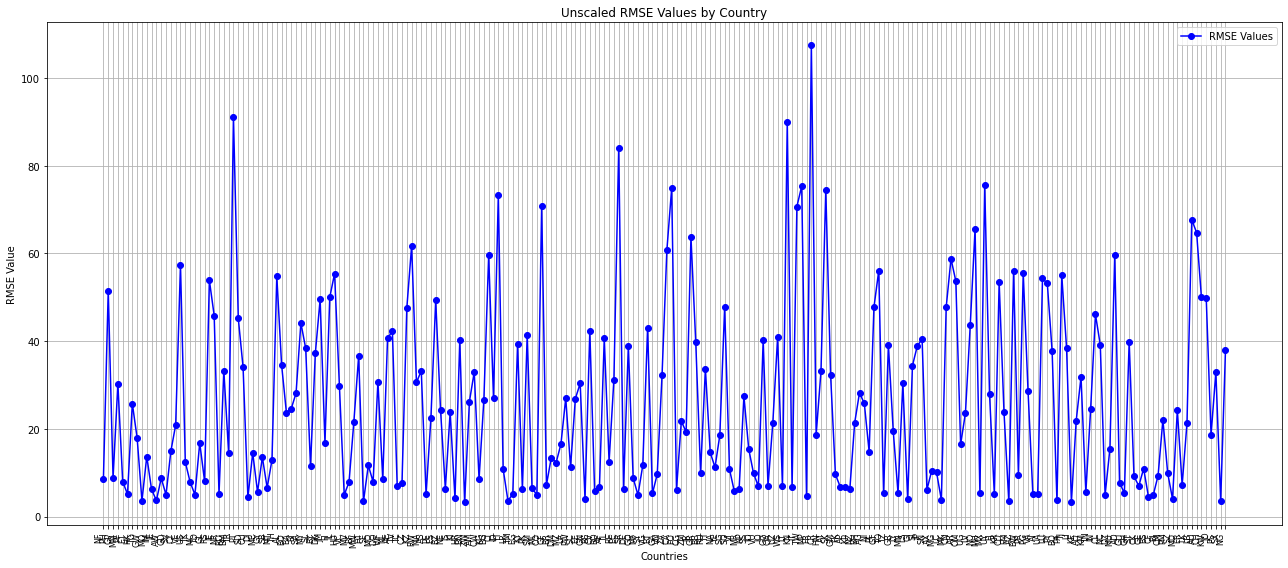

26.39519872428947


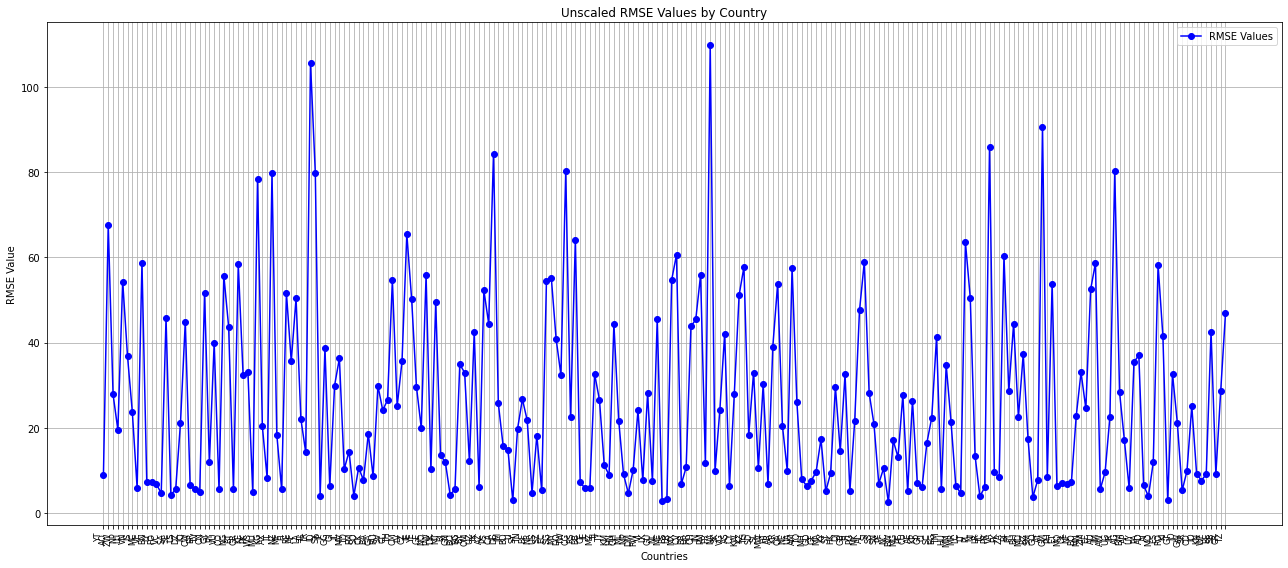

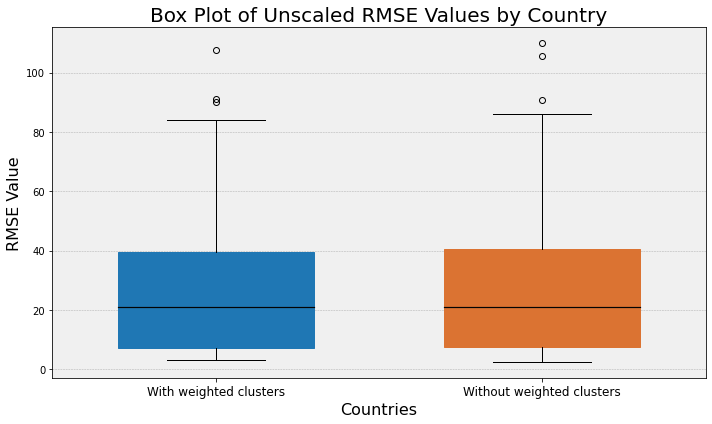

Outlier Countries (IQR): ['TR', 'LT', 'FR']
Outlier RMSE Values (IQR): [91.11617094369065, 90.02740149188246, 107.49020539144801]


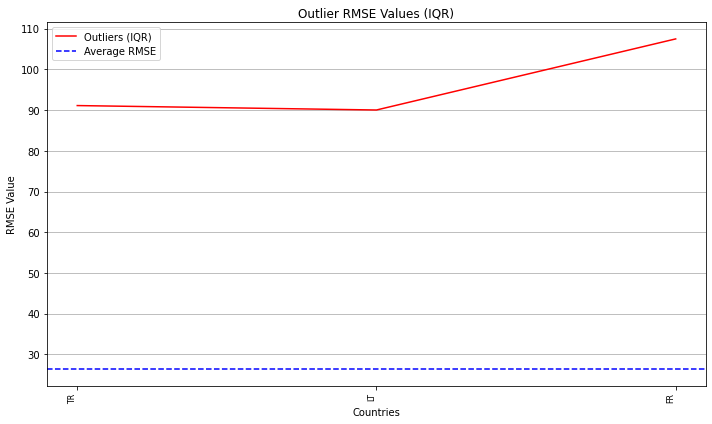

Outlier Countries (IQR): ['TR', 'FR', 'AT']
Outlier RMSE Values (IQR): [105.7231745568851, 109.83812750247736, 90.74957602866928]


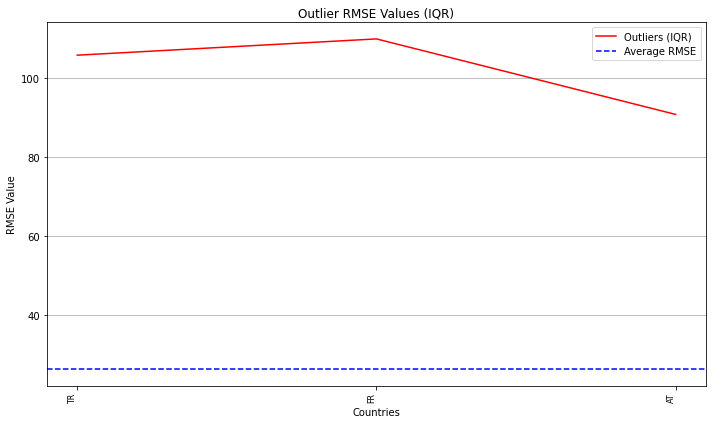

In [12]:
# Run the plots for the results

# Folders containing the prediction results for 2 best performing models
results_dir1 = 'results5/'
results_dir2 = 'results4/'

av1, values1 = reg_res(results_dir1)
av2, values2 = reg_res(results_dir2)
output1 = acc(av1, results_dir1, values1)
output2 = acc(av2, results_dir2, values2)

boxplot(output1, output2)
outliers(output1,results_dir1)
outliers(output2,results_dir2)

### Now check the details of the prediction of China

In [65]:
china = results_df = pd.read_csv(os.path.join('results4', 'HK_regression_results.csv'))
china['unscaled_RMSE'] = china.apply(calculate_unscaled_rmse, axis=1)
china_renamed = china.rename(columns={'year': 'year', 'preds': 'pred_without_weight', 'unscaled_RMSE': 'RMSE_without_weights'})

# Keep only the required columns
china_filtered = china_renamed[['year', 'pred_without_weight', 'RMSE_without_weights']]

# Display the resulting DataFrame
china_filtered


,year,pred_without_weight,RMSE_without_weights
0,2016,17027.705001,1.294999
1,2017,36709.630813,87.369187
2,2018,47161.356771,9.356771
3,2019,43487.651196,7.348804
4,2020,29698.434667,92.565333
5,2021,55177.108123,2.108123
6,2022,40581.115270,7.115270


In [66]:
china = results_df = pd.read_csv(os.path.join('results5', 'HK_regression_results_k6_w15.csv'))
china['unscaled_RMSE'] = china.apply(calculate_unscaled_rmse, axis=1)
china_renamed = china.rename(columns={'year': 'year', 'preds': 'pred_with_weight', 'unscaled_RMSE': 'RMSE_with_weights'})

# Keep only the required columns
china_filtered2 = china_renamed[['actual', 'year', 'pred_with_weight', 'RMSE_with_weights']]

# Merge the two DataFrames on the 'year' column
merged_df = pd.merge(china_filtered, china_filtered2, on='year')


df_rearranged = merged_df[['year', 'actual', 'pred_with_weight', 'pred_without_weight', 'RMSE_with_weights', 'RMSE_without_weights']]

df_rearranged

,year,actual,pred_with_weight,pred_without_weight,RMSE_with_weights,RMSE_without_weights
0,2016,17029,17025.005369,17027.705001,3.994631,1.294999
1,2017,36797,36731.367622,36709.630813,65.632378,87.369187
2,2018,47152,47160.637170,47161.356771,8.637170,9.356771
3,2019,43495,43510.653833,43487.651196,15.653833,7.348804
4,2020,29791,29723.051336,29698.434667,67.948664,92.565333
5,2021,55175,55168.786908,55177.108123,6.213092,2.108123
6,2022,40574,40586.300455,40581.115270,12.300455,7.115270


# Extra Plots

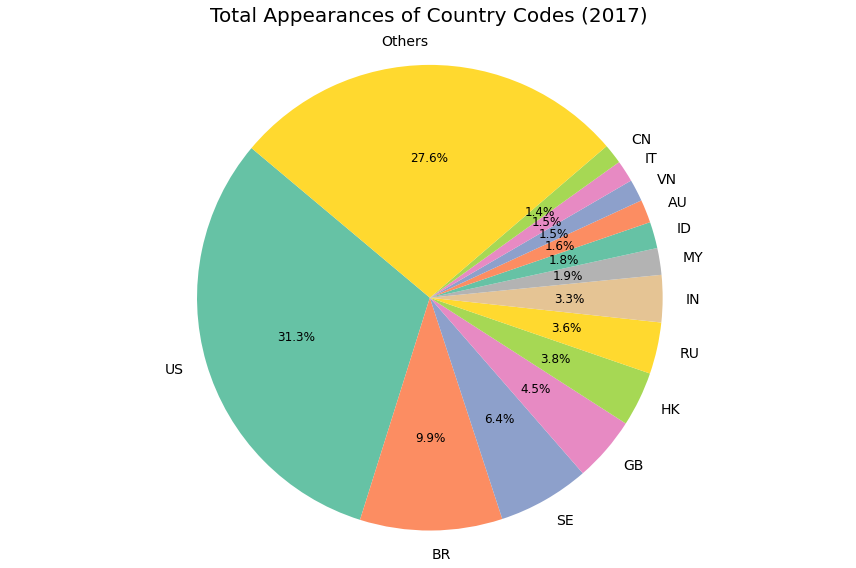

In [215]:
def plot_pie_chart(df, category, year, top_n=5):
    pandas_df = df.toPandas()
    percentage_col = f"Percentage_Total_{category}_{year}"

    # Sort the DataFrame and select top N countries
    sorted_df = pandas_df.sort_values(by=percentage_col, ascending=False)
    top_countries = sorted_df.head(top_n)

    # Calculate remaining countries
    others_sum = sorted_df.iloc[top_n:][percentage_col].sum()
    top_countries = top_countries.append({'country_code': 'Others', percentage_col: others_sum}, ignore_index=True)
    
    plt.figure(figsize=(12, 8))
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

    # Plot pie chart
    wedges, texts, autotexts = plt.pie(top_countries[percentage_col], labels=top_countries['country_code'],
                                       autopct='%1.1f%%', startangle=140, colors=colors[:top_n+1])
    for text in texts:
        text.set_fontsize(14)
    for autotext in autotexts:
        autotext.set_fontsize(12)
    
    plt.title(f"Total {category} of Country Codes ({year})", fontsize=20, pad=20)d
    plt.axis('equal')
    plt.gca().set_facecolor('#f0f0f0')
    plt.tight_layout()
    plt.show()


    
plot_pie_chart(add_normalized_df, category='Appearances', year=2017, top_n=13)


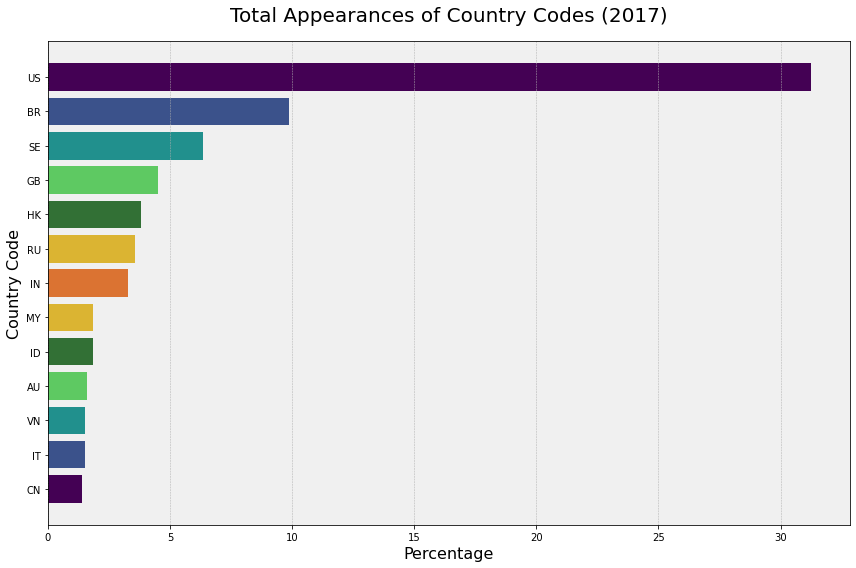

In [252]:
def plot_bar_chart(df, category, year, top_n=5):
    pandas_df = df.toPandas()
    percentage_col = f"Percentage_Total_{category}_{year}"

    # Sort the DataFrame and select top N countries
    sorted_df = pandas_df.sort_values(by=percentage_col, ascending=False)
    top_countries = sorted_df.head(top_n)

    # Reverse the DataFrame to get the largest to smallest order
    top_countries = top_countries.iloc[::-1]

    plt.figure(figsize=(12, 8))
    colors = ['#440154', '#3b528b', '#21908d', '#5ec962', '#327035', '#dbb432', '#db7332', '#dbb432', '#327035', '#5ec962', '#21908d', '#3b528b', '#440154'][::-1]

    plt.barh(top_countries['country_code'], top_countries[percentage_col], color=colors[:top_n])
    
    plt.title(f"Total {category} of Country Codes ({year})", fontsize=20, pad=20)
    plt.ylabel('Country Code', fontsize=16)
    plt.xlabel('Percentage', fontsize=16)
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')
    
    plt.tight_layout()
    plt.show()

    
plot_bar_chart(add_normalized_df, category='Appearances', year=2017, top_n=13)

/tmp/ipykernel_19252/1496520223.py:13: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_df_short[column_name], y=sorted_df_short["country_code"], palette="viridis")


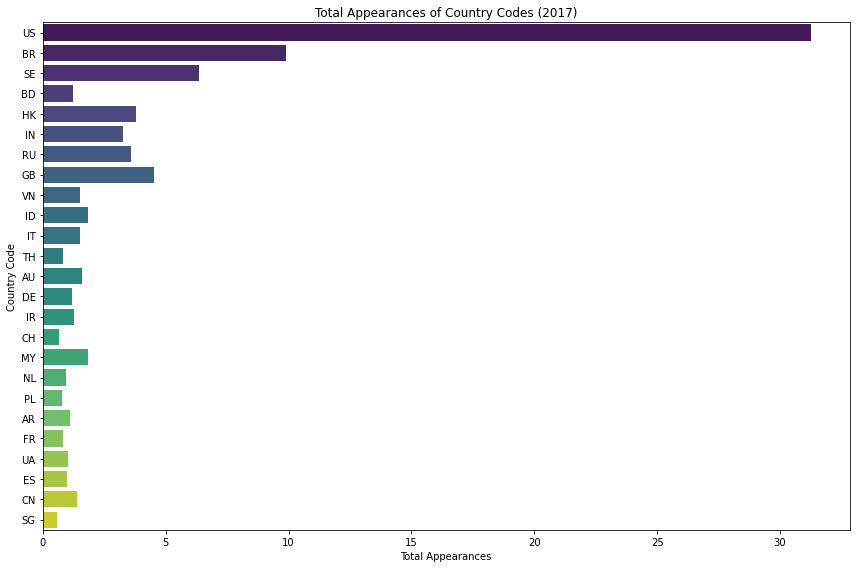

In [45]:
def plot_bars(df, category, mode=None, year=2022, top_n=5):

    # Sort by the total sum for the selected category
    total_sum_col = f"Total_{category}_Sum"
    sorted_df = df.orderBy(total_sum_col, ascending=False)
    pandas_df = sorted_df.toPandas()

    # Extract country codes and values for the top N rows
    column_name = f"{'_' + mode if mode else ''}_Total_{category}_{year}".strip('_')
    sorted_df_short = pandas_df[['country_code', column_name]].head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_df_short[column_name], y=sorted_df_short["country_code"], palette="viridis")

    plt.title(f"Total {category} of Country Codes ({year})")
    plt.xlabel(f"Total {category}")
    plt.ylabel("Country Code")
    plt.yticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()

plot_bars(add_normalized_df, 'Appearances', mode='Percentage', year=2017, top_n=25)

In [23]:
kh_row = sorted_df.loc[sorted_df['country_code'] == 'CN']
kh_row

,country_code,Total_Frequency_2016,Total_Frequency_2017,Total_Frequency_2018,Total_Frequency_2019,Total_Frequency_2020,Total_Frequency_2021,Total_Frequency_2022,Total_Frequency_Sum,Total_Appearances_2016,...,Normalized_Total_Frequency_2018,Normalized_Total_Appearances_2018,Normalized_Total_Frequency_2019,Normalized_Total_Appearances_2019,Normalized_Total_Frequency_2020,Normalized_Total_Appearances_2020,Normalized_Total_Frequency_2021,Normalized_Total_Appearances_2021,Normalized_Total_Frequency_2022,Normalized_Total_Appearances_2022
44,CN,406783,5063619,1049509,1249749,6027194,940441,1175003,15912298,3994,...,7.373332e+07,867727.300348,8.780119e+07,1.060893e+06,4.234409e+08,884287.946669,6.607074e+07,918926.24508,8.254991e+07,469766.12006


In [36]:
# Calculate percentage change between consecutive years
for year in range(2016, 2022):
    current_year = f'Percentage_Total_Appearances_{year}'
    next_year = f'Percentage_Total_Appearances_{year + 1}'
    kh_row[f'{year}-{year + 1}_Percentage_Change'] = ((kh_row[next_year] - kh_row[current_year]) / kh_row[current_year]) * 100

threshold = 25  # Percentage

# Check for significant changes
significant_changes = []
for year in range(2016, 2021):
    change_col = f'{year}-{year + 1}_Percentage_Change'
    if abs(kh_row.iloc[0][change_col]) >= threshold:
        significant_changes.append((year, year + 1))

if significant_changes:
    print("Significant changes in years:")
    for change in significant_changes:
        print(f"Change between {change[0]} and {change[1]}")
else:
    print("No significant changes")



Significant changes detected in the following years:
Change between 2016 and 2017
Change between 2017 and 2018


/tmp/ipykernel_6135/1927723038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kh_row[f'{year}-{year + 1}_Percentage_Change'] = ((kh_row[next_year] - kh_row[current_year]) / kh_row[current_year]) * 100


In [13]:
spark.stop()